In this test case a domain is tested with shear inflow profile at west, NoSlip walls at south, top and bottom, a FreeSlip wall north and an Outflow boundary at the eastern border.

Due to the FreeSlip wall at the northern boundary an almost zero velocity gradient should occure near the north boundary. This is tested here.

In [1]:
from dataclasses import replace

import pystencils as ps
import lbmpy as lp
from pystencils.slicing import slice_from_direction, make_slice

from lbmpy.boundaries.boundaryhandling import LatticeBoltzmannBoundaryHandling
from lbmpy.boundaries.boundaryconditions import FreeSlip, NoSlip, ExtrapolationOutflow, UBB


from lbmpy.creationfunctions import create_lb_method, create_lb_update_rule
from lbmpy.macroscopic_value_kernels import pdf_initialization_assignments

import lbmpy.plot as plt

import numpy as np

In [2]:
gpu = False
target = ps.Target.CPU

In [3]:
stencil = lp.LBStencil(lp.Stencil.D3Q27)
domain_size = (30, 15, 30)
dim = len(domain_size)

In [4]:
dh = ps.create_data_handling(domain_size=domain_size, periodicity=(False, False, False))

src = dh.add_array('src', values_per_cell=stencil.Q, alignment=True)
dh.fill('src', 0.0, ghost_layers=True)
dst = dh.add_array('dst', values_per_cell=stencil.Q, alignment=True)
dh.fill('dst', 0.0, ghost_layers=True)

velField = dh.add_array('velField', values_per_cell=stencil.D, alignment=True)
dh.fill('velField', 0.0, ghost_layers=True)

In [5]:
lbm_config = lp.LBMConfig(stencil=stencil, method=lp.Method.SRT, relaxation_rate=1.8,
                         output={'velocity': velField}, kernel_type='stream_pull_collide')
method = create_lb_method(lbm_config=lbm_config)

# Initialisation

In [6]:
init = pdf_initialization_assignments(method, 1.0, (0, 0, 0), src.center_vector)

config = ps.CreateKernelConfig(target=dh.default_target)
ast_init = ps.create_kernel(init, config=config)
kernel_init = ast_init.compile()

dh.run_kernel(kernel_init)

# Update Rules

In [7]:
lbm_opt = lp.LBMOptimisation(symbolic_field=src, symbolic_temporary_field=dst)
lbm_config = replace(lbm_config, lb_method=method)

update = create_lb_update_rule(lbm_config=lbm_config, lbm_optimisation=lbm_opt)

ast_kernel = ps.create_kernel(update, config=config)
kernel = ast_kernel.compile()

# Boundary Handling

In [8]:
def velocity_info_callback(boundary_data, **_):
    boundary_data['vel_1'] = 0
    boundary_data['vel_2'] = 0
    u_max = 0.1
    x, y = boundary_data.link_positions(0), boundary_data.link_positions(1)
    dist = (domain_size[1] - y) / domain_size[1]
    boundary_data['vel_0'] = u_max * (1 - dist)

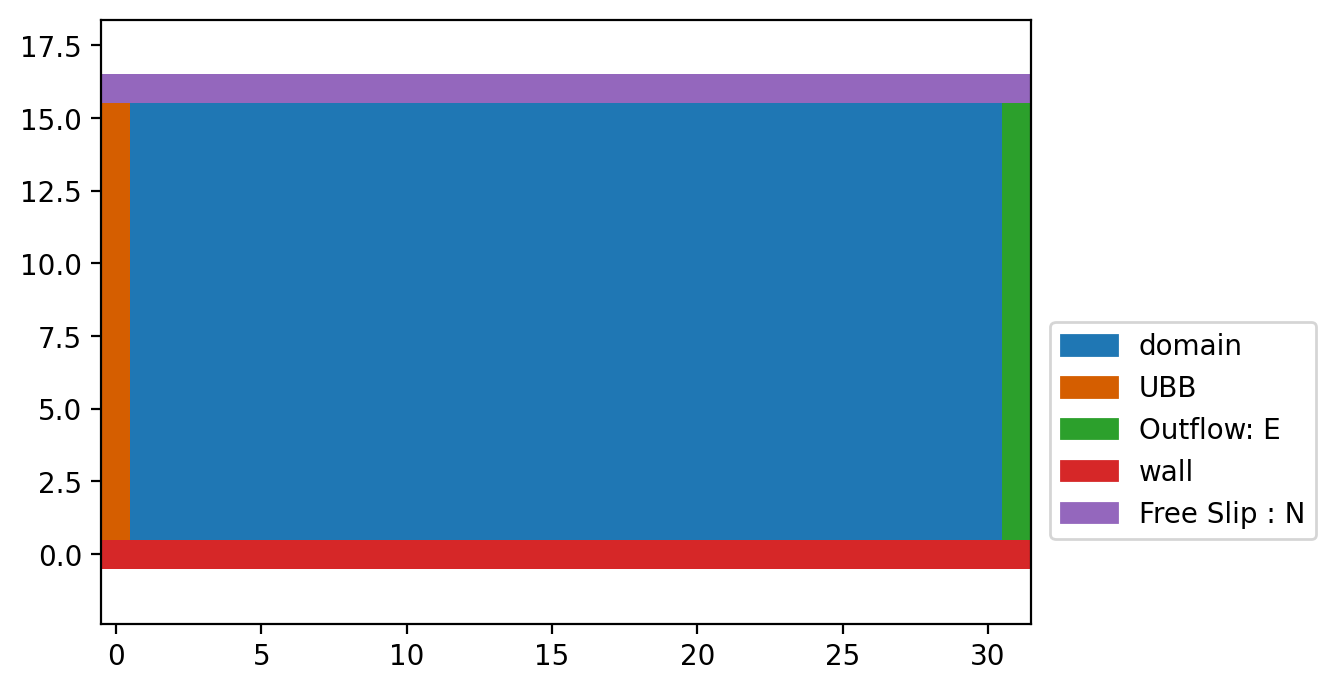

In [9]:
bh = LatticeBoltzmannBoundaryHandling(method, dh, 'src', name="bh")

inflow = UBB(velocity_info_callback, dim=dim)
outflow = ExtrapolationOutflow(stencil[4], method)
wall = NoSlip("wall")
freeslip = FreeSlip(stencil, (0, -1, 0))

bh.set_boundary(inflow, slice_from_direction('W', dim))
bh.set_boundary(outflow, slice_from_direction('E', dim))
bh.set_boundary(wall, slice_from_direction('S', dim))
bh.set_boundary(wall, slice_from_direction('T', dim))
bh.set_boundary(wall, slice_from_direction('B', dim))
bh.set_boundary(freeslip, slice_from_direction('N', dim))

plt.figure(dpi=200)
plt.boundary_handling(bh, make_slice[:, :, domain_size[2]//2])

In [10]:
def timeloop(timeSteps):
    for i in range(timeSteps):
        bh()
        dh.run_kernel(kernel)
        dh.swap("src", "dst")

In [11]:
timeloop(5000)

In [12]:
vel_profile = dh.gather_array('velField')[-2, :, domain_size[2] // 2, 0]

In [13]:
np.max(vel_profile)

0.07369491639715217

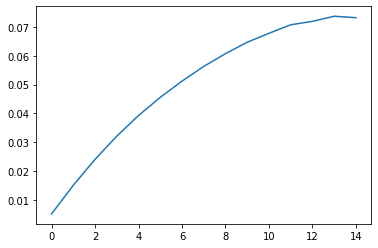

In [14]:
plt.plot(vel_profile)

At the FreeSlip wall the gradient of the velocity should be almost zero

In [15]:
np.testing.assert_almost_equal(np.gradient(vel_profile)[-1], 0, decimal=3)